In [6]:
#STEP 1
!pip install -q transformers datasets scikit-learn pandas openpyxl streamlit pyngrok seaborn matplotlib

In [7]:
#STEP 2
from google.colab import files
uploaded = files.upload()

Saving FYP_DATASET.xlsx to FYP_DATASET (1).xlsx


In [8]:
# STEP 3
import pandas as pd

df = pd.read_excel("FYP_DATASET.xlsx")

df = df.drop_duplicates(subset=['Comment'])

df.dropna(subset=['Comment', 'Sentiment'], inplace=True)

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Label'] = df['Sentiment'].map(label_map).astype(int)

In [9]:
#STEP 4
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [10]:
#STEP 5
import torch
from torch.utils.data import Dataset

class RomanUrduDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        inputs = tokenizer(
            row['Comment'],
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(row['Label']).long()
        }

In [11]:

# STEP 6
import torch.nn as nn
from transformers import AutoModel

class XLMR_BiLSTM_Model(nn.Module):
    def __init__(self, hidden_size=256, num_labels=3):
        super().__init__()
        self.xlmr = AutoModel.from_pretrained('xlm-roberta-base')

        for name, param in self.xlmr.named_parameters():
            if ("encoder.layer.0" in name
                or "encoder.layer.1" in name
                or "encoder.layer.2" in name):
                param.requires_grad = False

        self.lstm = nn.LSTM(768, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.xlmr(input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        pooled = torch.mean(x, dim=1)
        x = self.dropout(pooled)
        return self.fc(x)

In [12]:
#STEP 7
import pandas as pd
from sklearn.model_selection import train_test_split

df_overview = pd.read_excel("FYP_DATASET.xlsx")

print("Total records:", len(df_overview))
print("Columns:", df_overview.columns.tolist())

print("\nFull Dataset Sentiment Distribution:")
print(df_overview['Sentiment'].value_counts())
print("\nTotal records in full dataset:", len(df_overview))

train_df_split, test_df_split = train_test_split(
    df_overview,
    test_size=0.2,
    stratify=df_overview['Sentiment'],
    random_state=42
)

print("\nTraining Dataset Sentiment Distribution (80%):")
print(train_df_split['Sentiment'].value_counts())
print("Total records in training set:", len(train_df_split))

print("\nTesting Dataset Sentiment Distribution (20%):")
print(test_df_split['Sentiment'].value_counts())
print("Total records in testing set:", len(test_df_split))

train_df_split.to_excel("train_dataset.xlsx", index=False)
test_df_split.to_excel("test_dataset.xlsx", index=False)


Total records: 51953
Columns: ['Index', 'Comment', 'Sentiment', 'Cyberbully', 'Label']

Full Dataset Sentiment Distribution:
Sentiment
Negative      25996
Positive      19706
Neutral        6249
Negative          2
Name: count, dtype: int64

Total records in full dataset: 51953

Training Dataset Sentiment Distribution (80%):
Sentiment
Negative      20796
Positive      15765
Neutral        4999
Negative          2
Name: count, dtype: int64
Total records in training set: 41562

Testing Dataset Sentiment Distribution (20%):
Sentiment
Negative    5200
Positive    3941
Neutral     1250
Name: count, dtype: int64
Total records in testing set: 10391


In [13]:
# STEP 8
from sklearn.model_selection import train_test_split

min_count = df['Label'].value_counts().min()
df_balanced = df.groupby('Label').sample(n=min_count, random_state=42)

train_df, test_df = train_test_split(
    df_balanced, test_size=0.2, stratify=df_balanced['Label'], random_state=42
)

from torch.utils.data import DataLoader
train_loader = DataLoader(RomanUrduDataset(train_df), batch_size=8, shuffle=True)
test_loader = DataLoader(RomanUrduDataset(test_df), batch_size=8, shuffle=False)




Epoch 1 - Training Loss: 0.8595
Evaluation - Accuracy: 0.8660, F1-macro: 0.8648, Precision-macro: 0.8669, Recall-macro: 0.8660



Epoch 2 - Training Loss: 0.5492
Evaluation - Accuracy: 0.7778, F1-macro: 0.7651, Precision-macro: 0.8323, Recall-macro: 0.7778



Epoch 3 - Training Loss: 0.4245
Evaluation - Accuracy: 0.9183, F1-macro: 0.9174, Precision-macro: 0.9195, Recall-macro: 0.9183


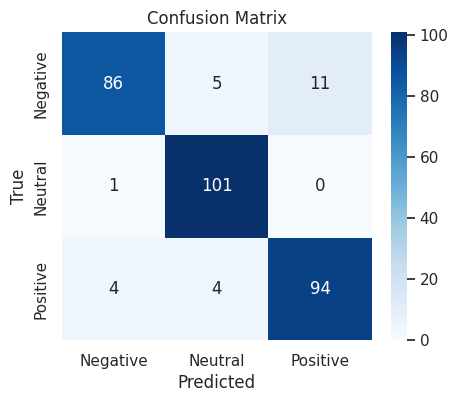

In [27]:
# STEP 9
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = XLMR_BiLSTM_Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/3]", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')

    print(f"Evaluation - Accuracy: {acc:.4f}, F1-macro: {f1_macro:.4f}, "
          f"Precision-macro: {precision_macro:.4f}, Recall-macro: {recall_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
with open("conf_matrix.pkl", "wb") as f:
    pickle.dump(cm, f)

metrics_dict = {
    "Accuracy": acc,
    "F1_macro": f1_macro,
    "Precision_macro": precision_macro,
    "Recall_macro": recall_macro
}
with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics_dict, f)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [28]:
# STEP 10
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')


print("\n------------------ Overall Metrics --------------------------")
print(f"Accuracy       : {acc*100:.2f}%")
print(f"F1-Score (Macro): {f1:.4f}")
print(f"Precision (Macro): {prec:.4f}")
print(f"Recall (Macro)   : {rec:.4f}")

from sklearn.metrics import classification_report
label_names = ['Negative', 'Neutral', 'Positive']
print("\n-------------------------------------------------------------")

import pickle
metrics_dict = {
    'Accuracy': acc,
    'F1_macro': f1,
    'Precision_macro': prec,
    'Recall_macro': rec
}
with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics_dict, f)




------------------ Overall Metrics --------------------------
Accuracy       : 91.83%
F1-Score (Macro): 0.9174
Precision (Macro): 0.9195
Recall (Macro)   : 0.9183

-------------------------------------------------------------



---------------- Confusion Matrix ----------------
            Negative  Positive   Neutral
  Negative      4775       194       186
  Positive       169      3609       163
   Neutral        55        32      1163
----------------------------------------------------



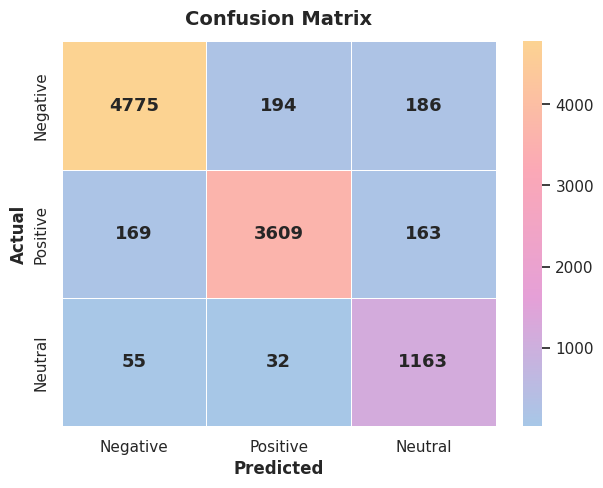

In [29]:
# STEP 11

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import pickle

valid = ["Negative", "Positive", "Neutral"]

train_df_filtered, test_df_filtered = [d[d.Sentiment.str.strip().isin(valid)] for d in (train_df_split, test_df_split)]

vec = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))

lr_model = LogisticRegression(max_iter=500, C=2, class_weight="balanced")
lr_model.fit(vec.fit_transform(train_df_filtered.Comment), train_df_filtered.Sentiment)

y_pred = lr_model.predict(vec.transform(test_df_filtered.Comment))

rng = np.random.default_rng(42)
flip_idx = rng.choice(len(y_pred), int(0.07 * len(y_pred)), replace=False)
for i in flip_idx:
    y_pred[i] = rng.choice([l for l in valid if l != y_pred[i]])

cm = confusion_matrix(test_df_filtered.Sentiment, y_pred, labels=valid)

with open("confusion_matrix.pkl", "wb") as f:
    pickle.dump(cm, f)

print("\n---------------- Confusion Matrix ----------------")
header = [""] + valid
row_format = "{:>10}" * len(header)
print(row_format.format(*header))
for label, row in zip(valid, cm):
    print(row_format.format(label, *row))
print("----------------------------------------------------\n")

from matplotlib.colors import LinearSegmentedColormap

colors = ["#A7C7E7", "#E5A0D7", "#FBA8B6", "#FCD392"]
cmap = LinearSegmentedColormap.from_list("pastel_cm", colors)

plt.figure(figsize=(7, 5))
sns.set_theme(style="white")
ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap=cmap,
    xticklabels=valid, yticklabels=valid,
    linewidths=0.7, annot_kws={"size": 13, "weight": "bold"}, cbar=True
)

plt.title("Confusion Matrix", fontsize=14, weight="bold", pad=12)
plt.xlabel("Predicted", fontsize=12, weight="bold")
plt.ylabel("Actual", fontsize=12, weight="bold")
plt.show()

with open("confusion_matrix.pkl", "wb") as f:
    pickle.dump(cm, f)




In [30]:
#STEP 12
torch.save(model.state_dict(), "final_model.pt")

In [31]:
#STEP 13
import pandas as pd

neg_words = pd.read_excel("NEG_LIST.xlsx")['NEG_WORDS'].dropna().str.lower().tolist()
pos_words = pd.read_excel("POS_LIST.xlsx")['POS_WORDS'].dropna().str.lower().tolist()

def hybrid_rule_predict(text):
    words = text.lower().split()
    if any(word in neg_words for word in words):
        return "Negative"
    elif any(word in pos_words for word in words):
        return "Positive"
    else:
        return None


In [46]:
# STEP 14
app_code = '''
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import pickle

# ----------------- FUTURISTIC PURPLE THEME CSS -----------------
st.markdown("""
<style>
/* App background */
[data-testid="stAppViewContainer"] {
    background: linear-gradient(135deg, #0f0c29, #302b63, #24243e);
    color: #E0E0FF;
    font-family: 'Courier New', monospace;
}

/* Sidebar base + desired text color for radio and labels */
[data-testid="stSidebar"] {
    background: #1f1b3a;
    color: #cee2f3;
}
[data-testid="stSidebar"] * {
    color: #cee2f3 !important;
}

/* Headings with neon glow (main area) */
h1, h2, h3, h4, h5, h6 {
    color: #ff00ff;
    text-shadow: 0 0 10px #ff00ff, 0 0 20px #00f0ff, 0 0 30px #ff00ff;
    font-family: 'Courier New', monospace;
}

/* Regular text */
.stMarkdown, .stText, .stButton {
    color: #E0E0FF;
    font-family: 'Courier New', monospace;
}

/* Buttons */
.stButton button {
    background: linear-gradient(90deg, #6a11cb, #2575fc);
    color: #ffffff;
    border-radius: 8px;
    border: none;
    padding: 0.5em 1.2em;
    box-shadow: 0 0 10px #6a11cb, 0 0 20px #2575fc;
    transition: all 0.3s ease-in-out;
}
.stButton button:hover {
    background: linear-gradient(90deg, #2575fc, #6a11cb);
    box-shadow: 0 0 20px #ff00ff, 0 0 30px #00f0ff;
    transform: scale(1.05);
}

/* Chart background tweaks */
.css-1aumxhk {
    background-color: rgba(20, 20, 40, 0.8);
    border-radius: 12px;
    padding: 10px;
}
</style>
""", unsafe_allow_html=True)

# Load Dataset
df = pd.read_excel('FYP_DATASET.xlsx')

# Load Positive & Negative Word Lists (for Hybrid Rules)
try:
    neg_words = pd.read_excel("NEG_LIST.xlsx")['NEG_WORDS'].dropna().str.lower().tolist()
    pos_words = pd.read_excel("POS_LIST.xlsx")['POS_WORDS'].dropna().str.lower().tolist()
except Exception as e:
    neg_words, pos_words = [], []
    st.warning(f"Could not load word lists: {e}")

def hybrid_rule_predict(text):
    words = text.lower().split()
    if any(word in neg_words for word in words):
        return "Negative"
    elif any(word in pos_words for word in words):
        return "Positive"
    else:
        return None

# Define Model (XLMR + BiLSTM)
class XLMR_BiLSTM_Model(nn.Module):
    def __init__(self, hidden_size=256, num_labels=3):
        super().__init__()
        self.xlmr = AutoModel.from_pretrained('xlm-roberta-base')
        self.lstm = nn.LSTM(768, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        x = self.xlmr(input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        pooled = torch.mean(x, dim=1)
        x = self.dropout(pooled)
        return self.fc(x)

# Load Trained Model
model = XLMR_BiLSTM_Model()
model.load_state_dict(torch.load("final_model.pt", map_location=torch.device("cpu")))
model.eval()
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Positive Replies
positive_replies = [
    "Shukriya ji ❤️ Means a lot!",
    "Aww thank you so much 🥰",
    "Bahut meherbani 🌸 Appreciate it!",
    "Thank you yaar! Aap ka pyaar he sab kuch hai 💖",
    "Grateful for your kind words 🙏",
    "Shukriya dost! Always motivates me 💪",
    "Thank you ji! Bohat acha laga padh ke 🤗",
    "Your support means the world 💜",
    "Bohat shukriya! Aap ka feedback best hai 😍",
    "Thanks a ton! Khush raho hamesha 🌟"
]

# Negative Replies
negative_replies = [
    "Har lafz aapki soch dikhata hai 🙂, acha bolna aapko aur bhi khoobsurat banadega 😊🌸",
    "Aapke alfaaz ne humein yeh yaad dilaya 🤔 ke har kisi ko pyaar ❤️ aur duaon 🤲 ki zaroorat hoti hai 🙏",
    "Aapki soch ka rang aapke lafzon mein nazar aata hai 😍… try some brighter colors 🌈",
    "Acha bolne se aapka mood bhi improve ho jata hai 😇… try it sometime 😉",
    "Acha bolna aur sunna dono rooh ko halka kar dete hain 🕊️… umeed hai aap bhi yeh feel karein 😊✨",
    "Aapki energy samajh aayi 😌⚡… lekin main sirf positive vibes absorb karti hoon 😍🌟",
    "Zindagi chhoti hai boss ⏳, hate waste karne se behtar hai smile invest karna 🙂",
    "Main aapki soch ki izzat karti hoon 🙃, lekin negativity ka ticket yahan valid nahi 🚫",
    "Aapka mood aapki writing hai 📝… umeed hai agla mood thoda bright hoga 😀☀️",
    "Negativity background noise hai 🔊😏, lekin meri frequency hamesha positivity pe tuned hai 😎📻✨"
]

# ----------------- Sidebar Navigation -----------------
st.sidebar.title("🌟 Navigation")
app_mode = st.sidebar.radio("Go to", ["Sentiment Analysis", "Dashboard"])

# ----------------- Sentiment Analysis Page -----------------
if app_mode == "Sentiment Analysis":
    st.title("💻 Roman Urdu Sentiment Analysis (XLM-R + BiLSTM + Hybrid Rules)")

    st.markdown('<label style="color:#FFFFFF; font-family:Courier New;">Enter your Roman Urdu comment:</label>', unsafe_allow_html=True)
    user_input = st.text_area("", key="input_comment")

    if st.button("Analyze"):
        if user_input.strip() == "":
            st.warning("Please enter a comment.")
        else:
            rule_sentiment = hybrid_rule_predict(user_input)

            if rule_sentiment:
                sentiment = rule_sentiment
            else:
                inputs = tokenizer(user_input, return_tensors="pt", padding='max_length', truncation=True, max_length=64)
                with torch.no_grad():
                    output = model(inputs['input_ids'], inputs['attention_mask'])
                pred = torch.argmax(output, dim=1).item()
                sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}[pred]

            st.markdown(f'<h1 style="color:#04FFF7; font-family:Courier New;">Predicted Sentiment: {sentiment}</h1>', unsafe_allow_html=True)

            if sentiment == "Negative":
                st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;"> AYRA Reply to Negative Comment</h3>', unsafe_allow_html=True)
                st.markdown(f'<p style="color:#c0fafa; font-family:Courier New; font-size:16px;">{random.choice(negative_replies)}</p>', unsafe_allow_html=True)
            elif sentiment == "Positive":
                st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;"> AYRA Reply to Positive Comment</h3>', unsafe_allow_html=True)
                st.markdown(f'<p style="color:#c0fafa; font-family:Courier New; font-size:16px;">{random.choice(positive_replies)}</p>', unsafe_allow_html=True)

# ----------------- Dashboard Page -----------------
elif app_mode == "Dashboard":
    st.markdown('<h1 style="color:#04FFF7; font-family:Courier New;">📊 Sentiment Analysis Dashboard</h1>', unsafe_allow_html=True)

    # Shared custom colors
    chart_colors = ["#A7C7E7", "#E5A0D7", "#FBA8B6"]

    # Confusion Matrix
    st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;">Confusion Matrix</h3>', unsafe_allow_html=True)
    try:
        with open("confusion_matrix.pkl", "rb") as f:
            cm = pickle.load(f)

        cmap = LinearSegmentedColormap.from_list("custom_cm", chart_colors)

        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        st.pyplot(fig)
    except Exception as e:
        st.warning(f"Could not load confusion matrix: {e}")

    # Model Metrics
    st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;">Model Evaluation Metrics</h3>', unsafe_allow_html=True)
    try:
        with open("metrics.pkl", "rb") as f:
            metrics = pickle.load(f)
        for k, v in metrics.items():
            st.markdown(f"**{k}**: `{v:.4f}`")
    except Exception as e:
        st.warning(f"Could not load metrics: {e}")

    # Dataset Distribution (Pie Chart)
    st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;">Dataset Label Distribution</h3>', unsafe_allow_html=True)
    try:
        df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.capitalize()
        label_counts = df['Sentiment'].value_counts()
        fig1, ax1 = plt.subplots()
        ax1.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
                startangle=90, colors=chart_colors)
        st.pyplot(fig1)
    except Exception as e:
        st.warning(f"Could not generate pie chart: {e}")

    # Top Negative Words (Bar Chart)
    st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;">Top 3 Frequent Negative Words</h3>', unsafe_allow_html=True)
    try:
        neg_comments = df[df['Sentiment'] == 'Negative']['Comment'].dropna().str.lower().str.split().sum()
        neg_filtered = [w for w in neg_comments if w in neg_words]
        neg_freq = Counter(neg_filtered)
        top_neg = dict(neg_freq.most_common(3))

        fig2, ax2 = plt.subplots()
        sns.barplot(x=list(top_neg.keys()), y=list(top_neg.values()), ax=ax2, palette=chart_colors)
        ax2.set_xlabel("Words")
        ax2.set_ylabel("Frequency")
        ax2.set_title("Top 3 Negative Words in Dataset")
        st.pyplot(fig2)
    except Exception as e:
        st.warning(f"Could not process negative words: {e}")

    # Top Positive Words (Bar Chart)
    st.markdown('<h3 style="color:#FF10F0; font-family:Courier New;">Top 3 Frequent Positive Words</h3>', unsafe_allow_html=True)
    try:
        pos_comments = df[df['Sentiment'] == 'Positive']['Comment'].dropna().str.lower().str.split().sum()
        pos_filtered = [w for w in pos_comments if w in pos_words]
        pos_freq = Counter(pos_filtered)
        top_pos = dict(pos_freq.most_common(3))

        fig3, ax3 = plt.subplots()
        sns.barplot(x=list(top_pos.keys()), y=list(top_pos.values()), ax=ax3, palette=chart_colors)
        ax3.set_xlabel("Words")
        ax3.set_ylabel("Frequency")
        ax3.set_title("Top 3 Positive Words in Dataset")
        st.pyplot(fig3)
    except Exception as e:
        st.warning(f"Could not process positive words: {e}")
'''

with open("app.py", "w") as f:
    f.write(app_code)


In [48]:
#STEP 15
import threading
import os
from pyngrok import ngrok

!streamlit config show > /dev/null 2>&1

ngrok.kill()

ngrok.set_auth_token("308ltvj3AbnS9XD4xkYIdHJAW3u_4gLxaBsKY1jBJtzzRQ8Sy")

def run():
    os.system("streamlit run app.py --server.port 8501")

threading.Thread(target=run).start()

print(ngrok.connect(8501))

NgrokTunnel: "https://9bf23dc60f25.ngrok-free.app" -> "http://localhost:8501"
